In [1]:
import os
import sys
import random
import joblib

import matplotlib.pyplot as plt

import torch
import numpy as np
import pandas as pd
import dotenv
import mlflow
from huggingface_hub import login

import catboost as cb

import sklearn
from sklearn.preprocessing import StandardScaler

# random_seed = 42
random_seed = 42 * 2

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
sklearn.utils.check_random_state(random_seed)

sys.path.append("../..")

from utils import get_quantile_from_median, calculate_sklearn_metrics
from utils.plotting import plot_forecasts_val_test

dotenv.load_dotenv("../../.env")

token = os.environ["HF_TOKEN"]
login(token=token)

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("rosstat_forecasting");

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
data_dir = '../../../data/rosstat/processed'

train_df = pd.read_csv(os.path.join(data_dir, 'train/data.csv'))[['code', 'nominal_wage', 'date']]
val_df = pd.read_csv(os.path.join(data_dir, 'val/data.csv'))[['code', 'nominal_wage', 'date']]
test_df = pd.read_csv(os.path.join(data_dir, 'test/data.csv'))[['code', 'nominal_wage', 'date']]

print(f"Обучающая выборка: {train_df.shape[0]} строк")
print(f"Валидационная выборка: {val_df.shape[0]} строк")
print(f"Тестовая выборка: {test_df.shape[0]} строк")

Обучающая выборка: 4140 строк
Валидационная выборка: 828 строк
Тестовая выборка: 828 строк


In [3]:
scale_columns = ['nominal_wage']
os.makedirs('./artifacts', exist_ok=True)

train_scaled = train_df.copy()
val_scaled = val_df.copy()
test_scaled = test_df.copy()

scalers = {}
for column in scale_columns:
    scaler = StandardScaler()
    
    train_scaled[column] = scaler.fit_transform(train_df[[column]])
    val_scaled[column] = scaler.transform(val_df[[column]])
    test_scaled[column] = scaler.transform(test_df[[column]])
    
    scalers[column] = scaler
    joblib.dump(scaler, f'./artifacts/scaler_{column}.joblib')

joblib.dump(scalers, './artifacts/all_column_scalers.joblib')

['./artifacts/all_column_scalers.joblib']

In [4]:
def prepare_data_for_ts2vec(df):
    df = df.copy()
    unique_codes = df['code'].unique()
    n_codes = len(unique_codes)
    series_length = df[df['code'] == unique_codes[0]].shape[0]

    data_array = np.zeros((n_codes, series_length, 1))

    for i, code in enumerate(unique_codes):
        data_array[i, :, 0] = df[df['code'] == code]['nominal_wage'].values

    return data_array

train_data = prepare_data_for_ts2vec(train_scaled)
val_data = prepare_data_for_ts2vec(val_scaled)
test_data = prepare_data_for_ts2vec(test_scaled)

print(train_data.shape, val_data.shape, test_data.shape)

(69, 60, 1) (69, 12, 1) (69, 12, 1)


In [5]:
from ts2vec.ts2vec import TS2Vec

model = TS2Vec(
    input_dims=1,
    device=0,
    output_dims=256
)
loss_log = model.fit(
    train_data,
    verbose=True
)

Epoch #0: loss=9.768235564231873
Epoch #1: loss=3.5609885454177856
Epoch #2: loss=2.8683817982673645
Epoch #3: loss=2.616297960281372
Epoch #4: loss=2.682842791080475
Epoch #5: loss=2.661718428134918
Epoch #6: loss=2.5160399675369263
Epoch #7: loss=2.3990926146507263
Epoch #8: loss=2.641883969306946
Epoch #9: loss=2.437460631132126
Epoch #10: loss=2.479618489742279
Epoch #11: loss=2.4858054518699646
Epoch #12: loss=2.459974944591522
Epoch #13: loss=2.383958876132965
Epoch #14: loss=2.2215867936611176
Epoch #15: loss=2.452454686164856
Epoch #16: loss=2.2364315390586853
Epoch #17: loss=2.2729411125183105
Epoch #18: loss=2.276017725467682
Epoch #19: loss=2.29061621427536
Epoch #20: loss=2.2987220287323
Epoch #21: loss=2.0909576416015625
Epoch #22: loss=2.217170238494873
Epoch #23: loss=2.2281067967414856
Epoch #24: loss=2.270309627056122
Epoch #25: loss=2.1340813636779785
Epoch #26: loss=2.1455481946468353
Epoch #27: loss=2.2059094309806824
Epoch #28: loss=2.149175703525543
Epoch #29: los

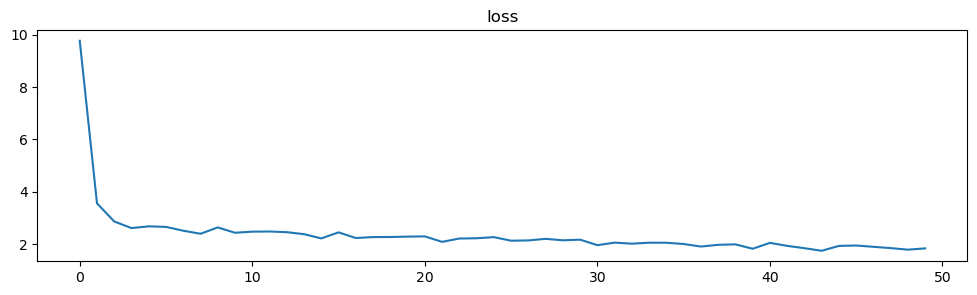

In [6]:
plt.figure(figsize=(12, 3))
plt.title('loss')
plt.plot(loss_log)
plt.show()

## All row embeddings

In [7]:
train_repr = model.encode(train_data, causal=True)
val_repr = model.encode(val_data, causal=True)
test_repr = model.encode(test_data, causal=True)

In [8]:
def create_df_from_ts2v_emb(ts2v_repr: np.ndarray, real_data: np.ndarray):
    data_rows = []
    for instance_idx in range(ts2v_repr.shape[0]):
        for time_idx in range(1, ts2v_repr.shape[1]):
            embedding = ts2v_repr[instance_idx, time_idx - 1]
            
            next_value = real_data[instance_idx, time_idx, 0]
            
            row = {'code': instance_idx}
            
            for emb_idx in range(embedding.shape[0]):
                row[f'emb_{emb_idx}'] = embedding[emb_idx]
            
            row['target'] = next_value
            row['time_step'] = time_idx
            
            row['current_value'] = real_data[instance_idx, time_idx, 0]
            
            data_rows.append(row)

    df_for_catboost = pd.DataFrame(data_rows)
    return df_for_catboost

train_df_emb = create_df_from_ts2v_emb(ts2v_repr=train_repr, real_data=train_data)

temp_val_repr = np.concatenate([train_repr[:, [-1], :], val_repr], axis=1)
temp_val_data = np.concatenate([train_data[:, [-1], :], val_data], axis=1)
val_df_emb = create_df_from_ts2v_emb(ts2v_repr=temp_val_repr, real_data=temp_val_data)

temp_test_repr = np.concatenate([val_repr[:, [-1], :], test_repr], axis=1)
temp_test_data = np.concatenate([val_data[:, [-1], :], test_data], axis=1)
test_df_emb = create_df_from_ts2v_emb(ts2v_repr=temp_test_repr, real_data=temp_test_data)

In [9]:
train_pool = cb.Pool(
   data=train_df_emb.drop(columns=['target']),
   label=train_df_emb['target'],
   cat_features=[]
)
val_pool = cb.Pool(
   data=val_df_emb.drop(columns=['target']),
   label=val_df_emb['target'],
   cat_features=[]
)
test_pool = cb.Pool(
   data=test_df_emb.drop(columns=['target']),
   label=test_df_emb['target'],
   cat_features=[]
)

In [10]:
cb_model = cb.CatBoostRegressor(random_seed = random_seed)

cb_model.fit(train_pool, eval_set=val_pool)

Learning rate set to 0.063477
0:	learn: 0.9474433	test: 1.4182863	best: 1.4182863 (0)	total: 65ms	remaining: 1m 4s
1:	learn: 0.8959405	test: 1.3639727	best: 1.3639727 (1)	total: 75.6ms	remaining: 37.7s
2:	learn: 0.8469829	test: 1.3014956	best: 1.3014956 (2)	total: 83.3ms	remaining: 27.7s
3:	learn: 0.8011277	test: 1.2451221	best: 1.2451221 (3)	total: 90.5ms	remaining: 22.5s
4:	learn: 0.7595901	test: 1.1986700	best: 1.1986700 (4)	total: 98.1ms	remaining: 19.5s
5:	learn: 0.7203879	test: 1.1462809	best: 1.1462809 (5)	total: 107ms	remaining: 17.7s
6:	learn: 0.6815264	test: 1.0928823	best: 1.0928823 (6)	total: 120ms	remaining: 17s
7:	learn: 0.6447559	test: 1.0422901	best: 1.0422901 (7)	total: 127ms	remaining: 15.8s
8:	learn: 0.6127055	test: 0.9996541	best: 0.9996541 (8)	total: 134ms	remaining: 14.8s
9:	learn: 0.5814436	test: 0.9591286	best: 0.9591286 (9)	total: 141ms	remaining: 13.9s
10:	learn: 0.5506174	test: 0.9149689	best: 0.9149689 (10)	total: 147ms	remaining: 13.2s
11:	learn: 0.5226725	

In [11]:
val_predictions_ = cb_model.predict(val_pool)
val_predictions_ = scalers['nominal_wage'].inverse_transform(val_predictions_.reshape(val_data.shape[:-1]))

test_predictions_ = cb_model.predict(test_pool)
test_predictions_ = scalers['nominal_wage'].inverse_transform(test_predictions_.reshape(test_data.shape[:-1]))

In [12]:
val_predictions = {}
test_predictions = {}

def get_predictions_df(predictions: np.ndarray, df: pd.DataFrame) -> pd.DataFrame:
    predictions_df = pd.DataFrame(predictions.flatten(), columns=['mean'])
    predictions_df['code'] = df['code']
    predictions_df['y_true'] = df['nominal_wage']
    predictions_df['0.1'] = get_quantile_from_median(predictions_df['mean'].values, 0.1)
    predictions_df['0.9'] = get_quantile_from_median(predictions_df['mean'].values, 0.9)
    predictions_df.set_index('code', inplace=True)

    return predictions_df

val_predictions_df = get_predictions_df(predictions=val_predictions_,  df=val_df)
test_predictions_df = get_predictions_df(predictions=test_predictions_,  df=test_df)

model_name = 'ts2vec + CatBoost'

val_predictions[model_name] = val_predictions_df
test_predictions[model_name] = test_predictions_df

In [13]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime
from utils.plotting import plot_forecasts_val_test


date_col = pd.to_datetime(test_df["date"])
min_date = date_col.min().date()
max_date = date_col.max().date()
height = 400
width = 1200

start_date_picker = widgets.DatePicker(
    description="Start date:", disabled=False, value=min_date
)

end_date_picker = widgets.DatePicker(
    description="End date:", disabled=False, value=max_date
)

output_area = widgets.Output()


def on_button_clicked(b):
    with output_area:
        clear_output(wait=True)
        start_date = datetime.datetime.combine(
            start_date_picker.value, datetime.datetime.min.time()
        )
        end_date = datetime.datetime.combine(
            end_date_picker.value, datetime.datetime.min.time()
        )
        plot_forecasts_val_test(
            val_df=val_df_,
            test_df=test_df_,
            val_predictions=all_val_models_predictions_,
            test_predictions=test_predictions,
            start_date=start_date,
            end_date=end_date,
            height=height,
            width=width,
            item_id=item_id,
        )


plot_button = widgets.Button(description="Plot Forecasts")
plot_button.on_click(on_button_clicked)

controls = widgets.VBox(
    [widgets.HBox([start_date_picker, end_date_picker]), plot_button]
)

display(controls, output_area)

item_id = 1

val_df_ = val_df.rename(columns={'date': 'timestamp', "nominal_wage": "target"})[['code', 'timestamp', "target"]]
val_df_ = val_df_[val_df_['code'].eq(item_id)].reset_index(drop=True)
val_df_['timestamp'] = pd.to_datetime(val_df_['timestamp'])

test_df_ = test_df.rename(columns={'date': 'timestamp', "nominal_wage": "target"})[['code', 'timestamp', "target"]]
test_df_ = test_df_[test_df_['code'].eq(item_id)].reset_index(drop=True)
test_df_['timestamp'] = pd.to_datetime(test_df_['timestamp'])

val_df_ = pd.concat([val_df_, test_df_.iloc[[0]]])

all_val_models_predictions_ = val_predictions.copy()
for model_ in all_val_models_predictions_.keys():
    all_val_models_predictions_[model_] = pd.concat([all_val_models_predictions_[model_], test_predictions[model_].loc[[item_id]].iloc[[0]]])

with output_area:
    plot_forecasts_val_test(
        val_df=val_df_,
        test_df=test_df_,
        val_predictions=all_val_models_predictions_,
        test_predictions=test_predictions,
        height=height,
        width=width,
        item_id=item_id,
    )

Output()

In [14]:
all_codes = train_df['code'].unique()

all_models_metrics = {}

for model_name in test_predictions.keys():
    metrics_df = []
    for code in all_codes:
        pred_df = pd.concat([
            test_predictions[model_name].rename(columns={'mean': '0.5'})
            .loc[code][["0.1", "0.5", "0.9"]]
            .reset_index(drop=True),
            test_df[test_df["code"].eq(code)][["nominal_wage"]].reset_index(drop=True),
        ], axis=1)
        pred_df = pd.DataFrame(pred_df)

        metrics_df.append(calculate_sklearn_metrics(pred_df, target_column='nominal_wage'))

    metrics_dict = pd.DataFrame(metrics_df).mean().to_dict()

    all_models_metrics[model_name] = metrics_dict

all_models_metrics

{'ts2vec + CatBoost': {'MSE': 30122744.924255956,
  'MAE': 2478.746526209966,
  'MAPE': 2.5176702975854885,
  'MASE': 0.4148673597591884,
  'SQL': 1310.510830286995}}

In [15]:
prefix = 'TS2V_all_row'

for k, metrics_ in all_models_metrics.items():
    run_name = f"{k}_{prefix}"

    with mlflow.start_run(run_name=run_name):
        mlflow.log_metrics(metrics_)
        mlflow.log_param("model_name", k)

        mlflow.set_tag("prefix", prefix)

🏃 View run ts2vec + CatBoost_TS2V_all_row at: http://127.0.0.1:5000/#/experiments/169882278836627198/runs/fae59305a38840d080b140c88cb54da3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/169882278836627198


## Sliding embeddings

In [16]:
# sliding_length создает своего рода "микро-батчи" по временной оси

sliding_length = 1
sliding_padding = 6


train_repr = model.encode(train_data, causal=True, sliding_length=sliding_length, sliding_padding=sliding_padding)

temp_val_data = np.concatenate([train_data[:, -sliding_padding:, :], val_data], axis=1)
val_repr = model.encode(temp_val_data, causal=True, sliding_length=sliding_length, sliding_padding=sliding_padding)
val_repr = val_repr[:, - (val_repr.shape[1] - sliding_padding):, :]

temp_test_data = np.concatenate([val_data[:, -sliding_padding:, :], test_data], axis=1)
test_repr = model.encode(temp_test_data, causal=True, sliding_length=sliding_length, sliding_padding=sliding_padding)
test_repr = test_repr[:, - (test_repr.shape[1] - sliding_padding):, :]
test_repr.shape

(69, 12, 256)

In [17]:
train_df_emb = create_df_from_ts2v_emb(ts2v_repr=train_repr, real_data=train_data)

temp_val_repr = np.concatenate([train_repr[:, [-1], :], val_repr], axis=1)
temp_val_data = np.concatenate([train_data[:, [-1], :], val_data], axis=1)
val_df_emb = create_df_from_ts2v_emb(ts2v_repr=temp_val_repr, real_data=temp_val_data)

temp_test_repr = np.concatenate([val_repr[:, [-1], :], test_repr], axis=1)
temp_test_data = np.concatenate([val_data[:, [-1], :], test_data], axis=1)
test_df_emb = create_df_from_ts2v_emb(ts2v_repr=temp_test_repr, real_data=temp_test_data)

train_pool = cb.Pool(
   data=train_df_emb.drop(columns=['target']),
   label=train_df_emb['target'],
   cat_features=[]
)
val_pool = cb.Pool(
   data=val_df_emb.drop(columns=['target']),
   label=val_df_emb['target'],
   cat_features=[]
)
test_pool = cb.Pool(
   data=test_df_emb.drop(columns=['target']),
   label=test_df_emb['target'],
   cat_features=[]
)

cb_model = cb.CatBoostRegressor(random_seed = random_seed)

cb_model.fit(train_pool, eval_set=val_pool)

val_predictions_ = cb_model.predict(val_pool)
val_predictions_ = scalers['nominal_wage'].inverse_transform(val_predictions_.reshape(val_data.shape[:-1]))

test_predictions_ = cb_model.predict(test_pool)
test_predictions_ = scalers['nominal_wage'].inverse_transform(test_predictions_.reshape(test_data.shape[:-1]))

val_predictions = {}
test_predictions = {}

def get_predictions_df(predictions: np.ndarray, df: pd.DataFrame) -> pd.DataFrame:
    predictions_df = pd.DataFrame(predictions.flatten(), columns=['mean'])
    predictions_df['code'] = df['code']
    predictions_df['y_true'] = df['nominal_wage']
    predictions_df['0.1'] = get_quantile_from_median(predictions_df['mean'].values, 0.1)
    predictions_df['0.9'] = get_quantile_from_median(predictions_df['mean'].values, 0.9)
    predictions_df.set_index('code', inplace=True)

    return predictions_df

val_predictions_df = get_predictions_df(predictions=val_predictions_,  df=val_df)
test_predictions_df = get_predictions_df(predictions=test_predictions_,  df=test_df)

model_name = 'ts2vec + CatBoost'

val_predictions[model_name] = val_predictions_df
test_predictions[model_name] = test_predictions_df

Learning rate set to 0.063477
0:	learn: 0.9490277	test: 1.4113658	best: 1.4113658 (0)	total: 8.49ms	remaining: 8.48s
1:	learn: 0.8993733	test: 1.3392806	best: 1.3392806 (1)	total: 14.6ms	remaining: 7.26s
2:	learn: 0.8521437	test: 1.2738259	best: 1.2738259 (2)	total: 20.8ms	remaining: 6.9s
3:	learn: 0.8055870	test: 1.2038922	best: 1.2038922 (3)	total: 26.8ms	remaining: 6.67s
4:	learn: 0.7643873	test: 1.1463033	best: 1.1463033 (4)	total: 32.5ms	remaining: 6.47s
5:	learn: 0.7225395	test: 1.0858491	best: 1.0858491 (5)	total: 38.9ms	remaining: 6.44s
6:	learn: 0.6837244	test: 1.0280258	best: 1.0280258 (6)	total: 44.9ms	remaining: 6.37s
7:	learn: 0.6467740	test: 0.9759790	best: 0.9759790 (7)	total: 50.9ms	remaining: 6.32s
8:	learn: 0.6132482	test: 0.9289645	best: 0.9289645 (8)	total: 56.8ms	remaining: 6.25s
9:	learn: 0.5825655	test: 0.8893755	best: 0.8893755 (9)	total: 62.6ms	remaining: 6.2s
10:	learn: 0.5524613	test: 0.8457851	best: 0.8457851 (10)	total: 68.4ms	remaining: 6.15s
11:	learn: 0.

In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime
from utils.plotting import plot_forecasts_val_test


date_col = pd.to_datetime(test_df["date"])
min_date = date_col.min().date()
max_date = date_col.max().date()
height = 400
width = 1200

start_date_picker = widgets.DatePicker(
    description="Start date:", disabled=False, value=min_date
)

end_date_picker = widgets.DatePicker(
    description="End date:", disabled=False, value=max_date
)

output_area = widgets.Output()


def on_button_clicked(b):
    with output_area:
        clear_output(wait=True)
        start_date = datetime.datetime.combine(
            start_date_picker.value, datetime.datetime.min.time()
        )
        end_date = datetime.datetime.combine(
            end_date_picker.value, datetime.datetime.min.time()
        )
        plot_forecasts_val_test(
            val_df=val_df_,
            test_df=test_df_,
            val_predictions=all_val_models_predictions_,
            test_predictions=test_predictions,
            start_date=start_date,
            end_date=end_date,
            height=height,
            width=width,
            item_id=item_id,
        )


plot_button = widgets.Button(description="Plot Forecasts")
plot_button.on_click(on_button_clicked)

controls = widgets.VBox(
    [widgets.HBox([start_date_picker, end_date_picker]), plot_button]
)

display(controls, output_area)

item_id = 1

val_df_ = val_df.rename(columns={'date': 'timestamp', "nominal_wage": "target"})[['code', 'timestamp', "target"]]
val_df_ = val_df_[val_df_['code'].eq(item_id)].reset_index(drop=True)
val_df_['timestamp'] = pd.to_datetime(val_df_['timestamp'])

test_df_ = test_df.rename(columns={'date': 'timestamp', "nominal_wage": "target"})[['code', 'timestamp', "target"]]
test_df_ = test_df_[test_df_['code'].eq(item_id)].reset_index(drop=True)
test_df_['timestamp'] = pd.to_datetime(test_df_['timestamp'])

val_df_ = pd.concat([val_df_, test_df_.iloc[[0]]])

all_val_models_predictions_ = val_predictions.copy()
for model_ in all_val_models_predictions_.keys():
    all_val_models_predictions_[model_] = pd.concat([all_val_models_predictions_[model_], test_predictions[model_].loc[[item_id]].iloc[[0]]])

with output_area:
    plot_forecasts_val_test(
        val_df=val_df_,
        test_df=test_df_,
        val_predictions=all_val_models_predictions_,
        test_predictions=test_predictions,
        height=height,
        width=width,
        item_id=item_id,
    )

Output()

In [19]:
all_codes = train_df['code'].unique()

all_models_metrics = {}

for model_name in test_predictions.keys():
    metrics_df = []
    for code in all_codes:
        pred_df = pd.concat([
            test_predictions[model_name].rename(columns={'mean': '0.5'})
            .loc[code][["0.1", "0.5", "0.9"]]
            .reset_index(drop=True),
            test_df[test_df["code"].eq(code)][["nominal_wage"]].reset_index(drop=True),
        ], axis=1)
        pred_df = pd.DataFrame(pred_df)

        metrics_df.append(calculate_sklearn_metrics(pred_df, target_column='nominal_wage'))

    metrics_dict = pd.DataFrame(metrics_df).mean().to_dict()

    all_models_metrics[model_name] = metrics_dict

all_models_metrics

{'ts2vec + CatBoost': {'MSE': 22557039.72861564,
  'MAE': 1688.8027945568435,
  'MAPE': 1.4654651872285485,
  'MASE': 0.24386207615803795,
  'SQL': 1174.1004495013874}}

In [20]:
prefix = f'TS2V_{sliding_length=}_{sliding_padding=}_max_pool'

for k, metrics_ in all_models_metrics.items():
    run_name = f"{k}_{prefix}"

    with mlflow.start_run(run_name=run_name):
        mlflow.log_metrics(metrics_)
        mlflow.log_param("model_name", k)

        mlflow.set_tag("prefix", prefix)

🏃 View run ts2vec + CatBoost_TS2V_sliding_length=1_sliding_padding=6_max_pool at: http://127.0.0.1:5000/#/experiments/169882278836627198/runs/193771ff8191414bbbba38bb800d5149
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/169882278836627198
